# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(96397, 42)
CPU times: user 369 ms, sys: 68.9 ms, total: 438 ms
Wall time: 440 ms


,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60,...,Card_Merchdesc_Zip_med_30,card_merch_med_0,Card_Merchnum_Zip_med_0,card_zip3_med_0,amount_cat,state_des_avg_3,Merchnum_desc_max_0,card_merch_total_30,Recnum,Fraud
0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,1,3.62,3.62,3.62,1,0
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,2,31.42,31.42,31.42,2,0
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,3,178.49,178.49,178.49,3,0
3,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,1,3.62,3.62,3.62,4,0
4,7.24,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,1,3.62,3.62,7.24,5,0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'card_merch_total_14',
 'card_zip3_max_14',
 'card_merch_avg_14',
 'Card_Merchdesc_Zip_med_14',
 'Card_Merchdesc_Zip_max_60',
 'Card_Merchnum_Zip_avg_60',
 'Card_Merchnum_desc_avg_60',
 'Merchdesc_dow_avg_30',
 'Card_Merchnum_desc_med_0',
 'Card_Merchdesc_max_60']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62


In [5]:
vars.shape

(96397, 12)

In [6]:
vars['Fraud'].sum()

1059

In [7]:
vars.head(10)

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
5,6,0,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67
6,7,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
7,8,0,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32
8,9,0,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11
9,10,0,10.86,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62


In [8]:
vars.shape

(96397, 12)

In [9]:
vars.describe()

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,48365.481820,0.010986,769.967286,529.353162,401.927811,394.564839,551.295774,404.503353,404.444849,396.465357,393.500463,552.096524
std,27945.003883,0.104236,4168.214517,1086.568630,790.425618,783.344833,1104.370845,778.326998,778.414021,696.170708,790.641417,1104.598654
min,1.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,24154.000000,0.000000,77.000000,57.190000,39.990000,39.180000,52.500000,44.900000,44.970000,53.035000,34.900000,52.770000
50%,48365.000000,0.000000,236.920000,212.660000,157.065000,149.970000,223.550000,171.030000,171.000000,200.000000,140.000000,224.300000
75%,72578.000000,0.000000,676.860000,609.000000,452.940000,438.450000,658.000000,472.000000,472.000000,478.200000,431.550000,659.340000
max,96753.000000,1.000000,306633.410000,47900.000000,28392.840000,28392.840000,47900.000000,28392.840000,28392.840000,28392.840000,28392.840000,47900.000000


In [10]:
# find the row i vars that corresponds to 11/1 (Recnum=84300)
test = vars[vars['Recnum'] > 84295]
test.head(10)

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
83966,84296,0,789.32,609.34,394.660,394.660,609.34,394.660000,394.660000,271.69250,394.66,609.34
83967,84297,0,235.00,235.00,235.000,235.000,235.00,235.000000,235.000000,235.00000,235.00,235.00
83968,84298,0,600.00,600.00,600.000,600.000,600.00,600.000000,600.000000,600.00000,600.00,600.00
83969,84299,0,30.00,30.00,30.000,30.000,365.32,197.660000,197.660000,294.10400,30.00,365.32
83970,84300,0,182.00,182.00,182.000,182.000,182.00,182.000000,182.000000,182.00000,182.00,182.00
83971,84301,0,399.61,225.00,199.805,199.805,225.00,199.805000,199.805000,174.61000,174.61,225.00
83972,84302,0,53.00,206.90,53.000,75.500,659.76,224.701429,224.701429,128.45875,53.00,659.76
83973,84303,0,25.00,531.25,25.000,25.000,28.48,26.740000,26.740000,25.00000,25.00,28.48
83974,84304,0,97.17,97.17,97.170,97.170,97.17,97.170000,97.170000,97.17000,97.17,97.17
83975,84305,0,6.51,6.51,6.510,6.510,6.51,11.733333,4.500000,6.51000,6.51,6.51


In [11]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [12]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,769.967286,529.353162,401.927811,394.564839,551.295774,404.503353,404.444849,396.465357,393.500463,552.096524
std,4168.214517,1086.568630,790.425618,783.344833,1104.370845,778.326998,778.414021,696.170708,790.641417,1104.598654
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,77.000000,57.190000,39.990000,39.180000,52.500000,44.900000,44.970000,53.035000,34.900000,52.770000
50%,236.920000,212.660000,157.065000,149.970000,223.550000,171.030000,171.000000,200.000000,140.000000,224.300000
75%,676.860000,609.000000,452.940000,438.450000,658.000000,472.000000,472.000000,478.200000,431.550000,659.340000
max,306633.410000,47900.000000,28392.840000,28392.840000,47900.000000,28392.840000,28392.840000,28392.840000,28392.840000,47900.000000


In [13]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [14]:
# use this to cap variables. For some problems it helps
Clip = 10

In [15]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,-4.580238e-16,1.642357e-15,9.159462e-15,-1.424971e-15,1.927932e-16,1.083906e-14,1.434370e-15,6.285712e-15,7.526706e-16,3.751579e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.847211e-01,-4.871696e-01,-5.084828e-01,-5.036796e-01,-4.991854e-01,-5.196959e-01,-5.195626e-01,-5.694801e-01,-4.976851e-01,-4.998073e-01
25%,-1.662504e-01,-4.345452e-01,-4.579024e-01,-4.536761e-01,-4.516561e-01,-4.620209e-01,-4.618042e-01,-4.933134e-01,-4.535564e-01,-4.520434e-01
50%,-1.278838e-01,-2.914617e-01,-3.097860e-01,-3.122441e-01,-2.967715e-01,-2.999682e-01,-2.998981e-01,-2.822086e-01,-3.206263e-01,-2.967562e-01
75%,-2.233745e-02,7.330125e-02,6.453762e-02,5.602279e-02,9.661992e-02,8.672017e-02,8.678563e-02,1.174060e-01,4.812490e-02,9.708818e-02
max,7.337997e+01,4.359655e+01,3.541246e+01,3.574195e+01,4.287392e+01,3.595961e+01,3.595567e+01,4.021481e+01,3.541345e+01,4.286435e+01


In [16]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
# oot_recnum=84300
oot_recnum = 83970
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    179
dtype: int64

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [18]:
alphas = 10**np.linspace(2,9,30)*0.5

In [19]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [20]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 10)

CPU times: user 1.04 s, sys: 31.3 ms, total: 1.07 s
Wall time: 523 ms


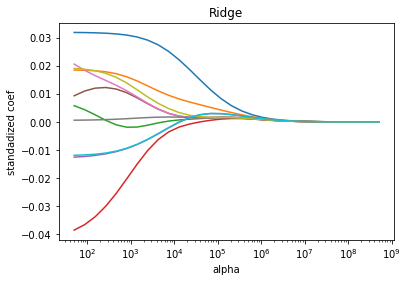

In [21]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [22]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [23]:
# %%time
# # sometimes this cell takes a long time
# lasso = Lasso(max_iter=10000) 
# coefs = [] 
# for a in alphas: 
#     lasso.set_params(alpha=a) 
#     lasso.fit(X_trn,Y_trn.values.ravel()) 
#     coefs.append(lasso.coef_) 
# # print('Shape:',np.shape(coefs)
# print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

No handles with labels found to put in legend.


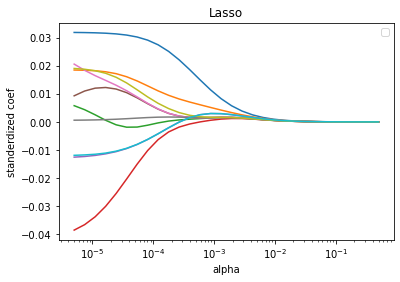

In [24]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [25]:
len(X_trntst.columns)

10

In [26]:
X_trntst_save = X_trntst.copy()

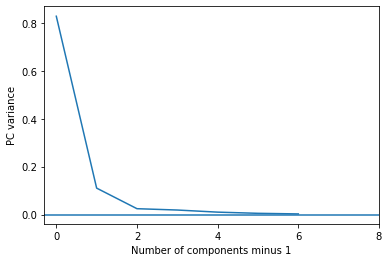

In [27]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [28]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-1.533139,0.129723,0.014924,0.112895
1,-1.436420,0.109263,0.007556,0.109120
2,-0.924754,0.001023,-0.031418,0.089151
3,-1.533139,0.129723,0.014924,0.112895
4,-1.532957,0.130397,0.014525,0.113179


In [29]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
83970,-0.912542,-0.001561,-0.032348,0.088675
83971,-0.839153,0.052569,-0.009732,0.102327
83972,-0.765169,0.276187,0.410126,-0.256049
83973,-1.304582,0.219003,0.089263,0.097301
83974,-1.207672,0.060872,-0.009868,0.100193


In [30]:
X_trntst.describe()

,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60
count,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000
mean,0.003015,0.001960,0.002997,0.002809,0.002998,0.002315,0.002318,0.002252,0.003263,0.002961
std,1.058833,1.010735,0.999406,0.998680,1.017370,0.996389,0.996397,0.988724,0.999310,1.017333
min,-0.184721,-0.487170,-0.508483,-0.503680,-0.499185,-0.519696,-0.519563,-0.569480,-0.497685,-0.499807
25%,-0.166286,-0.436791,-0.460066,-0.456017,-0.453920,-0.465389,-0.464977,-0.497610,-0.456238,-0.454551
50%,-0.127625,-0.293058,-0.309824,-0.312231,-0.299171,-0.300694,-0.300629,-0.282209,-0.320664,-0.298847
75%,-0.022093,0.074799,0.067220,0.058001,0.098431,0.090575,0.090640,0.119130,0.051436,0.098319
max,73.379967,43.596553,35.412456,35.741954,42.873917,35.959612,35.955667,40.214813,35.413449,42.864350


In [31]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12427.000000,12427.000000,12427.000000,12427.000000
mean,-0.065318,-0.007258,0.004024,-0.004344
std,2.792001,0.646520,0.468131,0.387631
min,-1.545698,-19.899470,-9.303463,-14.058395
25%,-1.293270,-0.103707,-0.097399,-0.052476
50%,-0.821140,0.063737,-0.007941,0.071681
75%,0.193802,0.132513,0.045297,0.107818
max,93.147610,11.290805,15.513500,8.803248


In [32]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [33]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.397000e+04,8.397000e+04,8.397000e+04,8.397000e+04
mean,2.839709e-16,7.573468e-17,-2.471312e-16,5.637188e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.324738e-01,-1.960193e+01,-3.067537e+01,-3.690457e+01
25%,-4.668320e-01,-9.418230e-02,-1.954183e-01,-1.200531e-01
50%,-2.927865e-01,6.671806e-02,-1.164569e-02,1.825460e-01
75%,9.204663e-02,1.316668e-01,6.775808e-02,2.554804e-01
max,3.736512e+01,6.119428e+01,3.728152e+01,3.968844e+01


In [34]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12427.000000,12427.000000,12427.000000,12427.000000
mean,-0.022501,-0.006851,0.008091,-0.009948
std,0.961810,0.610333,0.941264,0.887663
min,-0.532474,-18.785671,-18.706326,-32.193259
25%,-0.445516,-0.097902,-0.195838,-0.120168
50%,-0.282872,0.060170,-0.015967,0.164146
75%,0.066763,0.125096,0.091078,0.246899
max,32.088195,10.658845,31.192750,20.159147


In [35]:
X_trntst_pca.shape

(83970, 4)

In [36]:
X_oot_orig_pca.shape

(12427, 4)

## Subsample the larger class if desired

In [37]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.010479933309515303
(1751, 10) 1751


In [38]:
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [39]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [40]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression()
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6329113924050633 0.6411290322580645 0.5418994413407822
1 0.6197411003236246 0.6068702290076335 0.44692737430167595
2 0.635 0.6178571428571429 0.5586592178770949
3 0.6477272727272727 0.6022727272727273 0.49162011173184356
4 0.6220839813374806 0.6582278481012658 0.553072625698324
5 0.6247960848287113 0.6441947565543071 0.5027932960893855
6 0.6472545757071547 0.5734767025089605 0.5307262569832403
7 0.6395348837209303 0.6007194244604317 0.547486033519553
8 0.6270096463022508 0.6201550387596899 0.5083798882681564
9 0.6116504854368932 0.6526717557251909 0.5083798882681564
trn    0.630771
tst    0.621757
oot    0.518994
dtype: float64
CPU times: user 6.8 s, sys: 137 ms, total: 6.94 s
Wall time: 1.77 s


In [41]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier()
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 1.0 0.5864661654135338 0.29608938547486036
1 1.0 0.6174242424242424 0.31843575418994413
2 1.0 0.5795053003533569 0.21787709497206703
3 1.0 0.5793650793650794 0.33519553072625696
4 1.0 0.551094890510949 0.2737430167597765
5 1.0 0.5605536332179931 0.2737430167597765
6 1.0 0.6190476190476191 0.3407821229050279
7 1.0 0.5902255639097744 0.3128491620111732
8 1.0 0.536 0.35195530726256985
9 1.0 0.6245353159851301 0.2737430167597765
trn    1.000000
tst    0.584422
oot    0.299441
dtype: float64
CPU times: user 7.42 s, sys: 45.6 ms, total: 7.46 s
Wall time: 6.92 s


In [42]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier()
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 1.0 0.803030303030303 0.3687150837988827
1 1.0 0.8142292490118577 0.4245810055865922
2 1.0 0.8577405857740585 0.3687150837988827
3 1.0 0.8482142857142857 0.4301675977653631
4 1.0 0.8269896193771626 0.36312849162011174
5 1.0 0.8201438848920863 0.35195530726256985
6 1.0 0.8206106870229007 0.5195530726256983
7 1.0 0.8127659574468085 0.5307262569832403
8 1.0 0.8611111111111112 0.35195530726256985
9 1.0 0.8414634146341463 0.41899441340782123
trn    1.000000
tst    0.830630
oot    0.412849
dtype: float64
CPU times: user 2min 10s, sys: 617 ms, total: 2min 10s
Wall time: 2min 11s


In [43]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier()

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.9888712241653418 0.7649402390438247 0.3128491620111732
1 0.9804241435562806 0.7865168539325843 0.3463687150837989
2 0.9867768595041322 0.8 0.3128491620111732
3 0.9841269841269841 0.808 0.3463687150837989
4 0.9834437086092715 0.8043478260869565 0.3407821229050279
5 0.9851485148514851 0.791970802919708 0.37988826815642457
6 0.9886914378029079 0.7854406130268199 0.35195530726256985
7 0.9839486356340289 0.7937743190661478 0.3463687150837989
8 0.9826771653543307 0.7877551020408163 0.3463687150837989
9 0.9773095623987034 0.7870722433460076 0.35195530726256985
trn    0.984142
tst    0.790982
oot    0.343575
dtype: float64
CPU times: user 28.9 s, sys: 880 ms, total: 29.8 s
Wall time: 4.09 s


In [44]:
%%time
# LGBM with SMOTE
from imblearn.over_sampling import SMOTE

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    sm = SMOTE()
    
    X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
    print(niter, X_trn.shape,Y_trn.shape)
    print(niter, X_trn_sm.shape,Y_trn_sm.shape)
    print(Y_trn.sum())
    print(Y_trn_sm.sum())

    model = lgb.LGBMClassifier()
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 (58779, 10) (58779, 1)
0 (116300, 10) (116300, 1)
Fraud    629
dtype: int64
Fraud    58150
dtype: int64
0 0.9109697933227345 0.8207171314741036 0.31843575418994413
1 (58779, 10) (58779, 1)
1 (116280, 10) (116280, 1)
Fraud    639
dtype: int64
Fraud    58140
dtype: int64
1 0.9280125195618153 0.7966804979253111 0.33519553072625696
2 (58779, 10) (58779, 1)
2 (116306, 10) (116306, 1)
Fraud    626
dtype: int64
Fraud    58153
dtype: int64
2 0.9217252396166135 0.7992125984251969 0.3016759776536313
3 (58779, 10) (58779, 1)
3 (116312, 10) (116312, 1)
Fraud    623
dtype: int64
Fraud    58156
dtype: int64
3 0.9293739967897271 0.8132295719844358 0.31843575418994413
4 (58779, 10) (58779, 1)
4 (116318, 10) (116318, 1)
Fraud    620
dtype: int64
Fraud    58159
dtype: int64
4 0.9016129032258065 0.823076923076923 0.3407821229050279
5 (58779, 10) (58779, 1)
5 (116372, 10) (116372, 1)
Fraud    593
dtype: int64
Fraud    58186
dtype: int64
5 0.924114671163575 0.7979094076655052 0.3128491620111732
6 (58779,

In [45]:
# %%time
# # LGBM with jitter

# jittersize = .1
# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     print(niter, X_trn.shape,Y_trn.shape)
    
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]
    
#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)
        
#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with jitter',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [46]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier()
                          
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7328990228013029 0.7255639097744361 0.44692737430167595
1 0.7178683385579937 0.7396694214876033 0.5307262569832403
2 0.7615262321144675 0.7091633466135459 0.40782122905027934
3 0.7288961038961039 0.678030303030303 0.547486033519553
4 0.7166392092257001 0.7106227106227107 0.39664804469273746
5 0.7138047138047138 0.7027972027972028 0.39664804469273746
6 0.7515527950310559 0.6949152542372882 0.3687150837988827
7 0.7433774834437086 0.6956521739130435 0.39106145251396646
8 0.7096247960848288 0.7153558052434457 0.43575418994413406
9 0.7335526315789473 0.7169117647058824 0.4692737430167598
trn    0.730974
tst    0.708868
oot    0.439106
dtype: float64
CPU times: user 9min 15s, sys: 8.27 s, total: 9min 23s
Wall time: 2min 23s


In [47]:
# %%time
# # NN on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier()

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [48]:
# %%time
# # GBC

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [49]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.9292763157894737 0.8088235294117647 0.3743016759776536
1 0.9392 0.8352941176470589 0.3687150837988827
2 0.9185303514376997 0.8464566929133859 0.3407821229050279
3 0.9336650082918739 0.8050541516245487 0.3575418994413408
4 0.9297385620915033 0.8059701492537313 0.4301675977653631
5 0.9408866995073891 0.7749077490774908 0.3575418994413408
6 0.9247135842880524 0.7955390334572491 0.3687150837988827
7 0.9320388349514563 0.8015267175572519 0.3743016759776536
8 0.9298531810766721 0.8089887640449438 0.4748603351955307
9 0.927536231884058 0.8262548262548263 0.3743016759776536
trn    0.930544
tst    0.810882
oot    0.382123
dtype: float64
CPU times: user 5min 53s, sys: 9.71 s, total: 6min 3s
Wall time: 58.9 s


In [50]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = lgb.LGBMClassifier()

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()


    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

94.42045454545455
0 0.8227272727272728 0.8227272727272728 0.4581005586592179
1 0.8284090909090909 0.8284090909090909 0.5027932960893855
2 0.8 0.8 0.5139664804469274
3 0.8420454545454545 0.8420454545454545 0.3743016759776536
4 0.8227272727272728 0.8227272727272728 0.4022346368715084
5 0.8284090909090909 0.8284090909090909 0.39106145251396646
6 0.8022727272727272 0.8022727272727272 0.4860335195530726
7 0.8227272727272728 0.8227272727272728 0.36312849162011174
8 0.8159090909090909 0.8159090909090909 0.3743016759776536
9 0.8125 0.8125 0.4748603351955307
trn    0.819773
tst    0.819773
oot    0.434078
dtype: float64
CPU times: user 40.5 s, sys: 901 ms, total: 41.4 s
Wall time: 5.87 s


In [51]:
# %%time
# # Catboost on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier()

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [52]:
# %%time
# # unsupervised model using pc's. 

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [53]:
# %%time
# # XGB

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = xgb.XGBClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [54]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier()
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [55]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC()
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [56]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.632911,0.641129,0.541899
1,log reg,0.619741,0.60687,0.446927
2,log reg,0.635,0.617857,0.558659
3,log reg,0.647727,0.602273,0.49162
4,log reg,0.622084,0.658228,0.553073
5,log reg,0.624796,0.644195,0.502793
6,log reg,0.647255,0.573477,0.530726
7,log reg,0.639535,0.600719,0.547486
8,log reg,0.62701,0.620155,0.50838
9,log reg,0.61165,0.652672,0.50838


In [57]:
df.shape

(80, 4)

In [58]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.632911
1,log reg,Trn,0.619741
2,log reg,Trn,0.635
3,log reg,Trn,0.647727
4,log reg,Trn,0.622084


In [59]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.632911
1,log reg,Trn,0.619741
2,log reg,Trn,0.635
3,log reg,Trn,0.647727
4,log reg,Trn,0.622084


In [60]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
                     mean       std      mean       std      mean       std
Model                                                                      
DT               1.000000  0.000000  0.584422  0.029833  0.299441  0.040731
LGBM             0.984142  0.003562  0.790982  0.012078  0.343575  0.019397
LGBM sampled     0.819773  0.012634  0.819773  0.012634  0.434078  0.058773
LGBM with SMOTE  0.918020  0.009674  0.805340  0.017753  0.321788  0.012685
NN               0.730974  0.017170  0.708868  0.017303  0.439106  0.060526
RF               1.000000  0.000000  0.830630  0.020177  0.412849  0.066282
cat boost        0.930544  0.006532  0.810882  0.020496  0.382123  0.039957
log reg          0.630771  0.011884  0.621757  0.026992  0.518994  0.034383

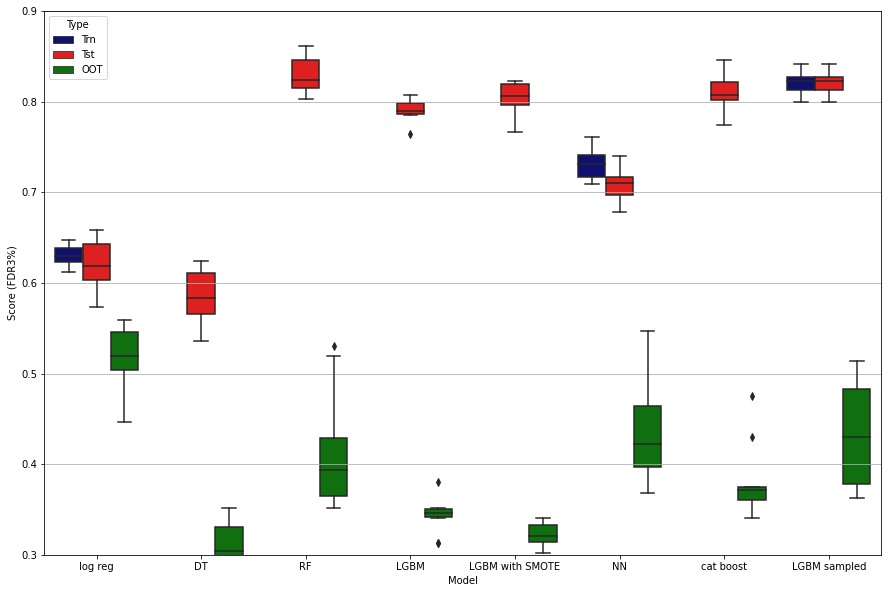

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.3,.9)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [62]:
print('duration: ', datetime.now() - start_time)

duration:  0:06:08.764642


0 0.6261829652996845 0.6097560975609756 0.4301675977653631
1 0.6266233766233766 0.6325757575757576 0.441340782122905
2 0.022764227642276424 0.033962264150943396 0.055865921787709494
3 0.6218905472636815 0.6064981949458483 0.5027932960893855
4 0.04019292604501608 0.015503875968992248 0.055865921787709494
5 0.0416 0.03137254901960784 0.061452513966480445
6 0.038523274478330656 0.019455252918287938 0.061452513966480445
7 0.6330128205128205 0.6015625 0.43575418994413406
8 0.6377049180327868 0.5925925925925926 0.4581005586592179
9 0.6261980830670927 0.5984251968503937 0.4245810055865922
loop trn tst oot 1 0.39146931389650663 0.3741704281583399 0.2927374301675978
0 0.7330097087378641 0.7519083969465649 0.4245810055865922
1 0.7634069400630915 0.6666666666666666 0.3854748603351955
2 0.7728026533996684 0.7184115523465704 0.3743016759776536
3 0.7712 0.7450980392156863 0.5307262569832403
4 0.750814332247557 0.7255639097744361 0.547486033519553
5 0.7666666666666667 0.7214285714285714 0.35195530726

/Users/stevecoggeshall/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


8 0.8879598662207357 0.7553191489361702 0.30726256983240224
9 0.8022328548644339 0.766798418972332 0.3687150837988827
loop trn tst oot 81 0.8382248973590152 0.7561875146541253 0.33184357541899445


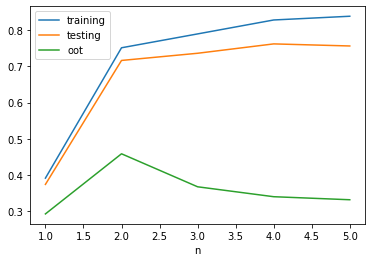

CPU times: user 1h 18min 28s, sys: 1min 1s, total: 1h 19min 30s
Wall time: 20min 33s


In [63]:
%%time
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,101,20):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = MLPClassifier(hidden_layer_sizes=(i,i))

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_NN.pdf', format='pdf')
plt.show()

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [64]:
%%time

for niter in range(100):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice

    model = MLPClassifier()

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR3.loc[niter, 'oot'] > .55): break
    
model_counter = model_counter + 1

0 0.7129629629629629 0.7025862068965517 0.39664804469273746
1 0.7255216693418941 0.7198443579766537 0.5586592178770949
CPU times: user 1min 27s, sys: 1.57 s, total: 1min 29s
Wall time: 23.1 s


In [65]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [66]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,card_merch_total_14,card_zip3_max_14,card_merch_avg_14,Card_Merchdesc_Zip_med_14,Card_Merchdesc_Zip_max_60,Card_Merchnum_Zip_avg_60,Card_Merchnum_desc_avg_60,Merchdesc_dow_avg_30,Card_Merchnum_desc_med_0,Card_Merchdesc_max_60,predicted,Fraud
89206,-0.119305,23.262218,-0.163517,-0.155595,-0.252285,-0.169368,-0.169273,-0.142688,-0.152813,-0.252958,0.999926,1
90369,1.283442,23.262218,7.233701,7.308487,5.042087,7.342835,7.342089,8.220921,7.242385,5.040323,0.999913,1
89186,9.768838,7.148446,1.131783,0.742253,7.013345,1.146067,1.382985,1.557548,0.095302,7.011174,0.999303,1
89183,9.722223,7.148446,1.176766,0.793514,7.013345,1.191749,1.454852,1.742342,0.144831,7.011174,0.999245,1
89174,9.315610,7.148446,1.161467,0.742253,7.013345,1.176212,1.445630,1.728709,0.095302,7.011174,0.998893,1
89130,9.112811,7.148446,1.242556,0.793514,7.013345,1.258561,1.505739,1.917739,0.060318,7.011174,0.998456,1
89121,6.919649,2.844300,0.990067,0.793514,2.778581,1.002148,1.126262,0.648317,0.005451,2.777283,0.983969,1
89128,7.032132,2.844300,0.955244,0.742253,2.778581,0.966783,1.074085,0.570554,0.025333,2.777283,0.983460,1
89120,6.526073,2.844300,0.966029,0.742253,2.778581,0.977736,1.100613,0.420585,-0.014432,2.777283,0.982486,1
89117,6.440982,2.844300,1.010629,0.793514,2.778581,1.023029,1.169116,0.540736,0.005451,2.777283,0.982083,1


In [67]:
cost_fraud = 1000
cost_fp = 30
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,124.0,64.0,60.0,51.612903,48.387097,124.0,64.0,60.0,0.522534,33.519553,32.997019,1.066667
2,2.0,125.0,107.0,18.0,85.600000,14.400000,249.0,171.0,78.0,1.396146,43.575419,42.179273,2.192308
3,3.0,124.0,102.0,22.0,82.258065,17.741935,373.0,273.0,100.0,2.228935,55.865922,53.636986,2.730000
4,4.0,124.0,123.0,1.0,99.193548,0.806452,497.0,396.0,101.0,3.233181,56.424581,53.191400,3.920792
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,124.0,121.0,3.0,97.580645,2.419355,11930.0,11752.0,178.0,95.950359,99.441341,3.490982,66.022472
97,97.0,124.0,123.0,1.0,99.193548,0.806452,12054.0,11875.0,179.0,96.954605,100.000000,3.045395,66.340782
98,98.0,124.0,124.0,0.0,100.000000,0.000000,12178.0,11999.0,179.0,97.967015,100.000000,2.032985,67.033520
99,99.0,125.0,125.0,0.0,100.000000,0.000000,12303.0,12124.0,179.0,98.987590,100.000000,1.012410,67.731844


Max possible savings: 20,724,000.0


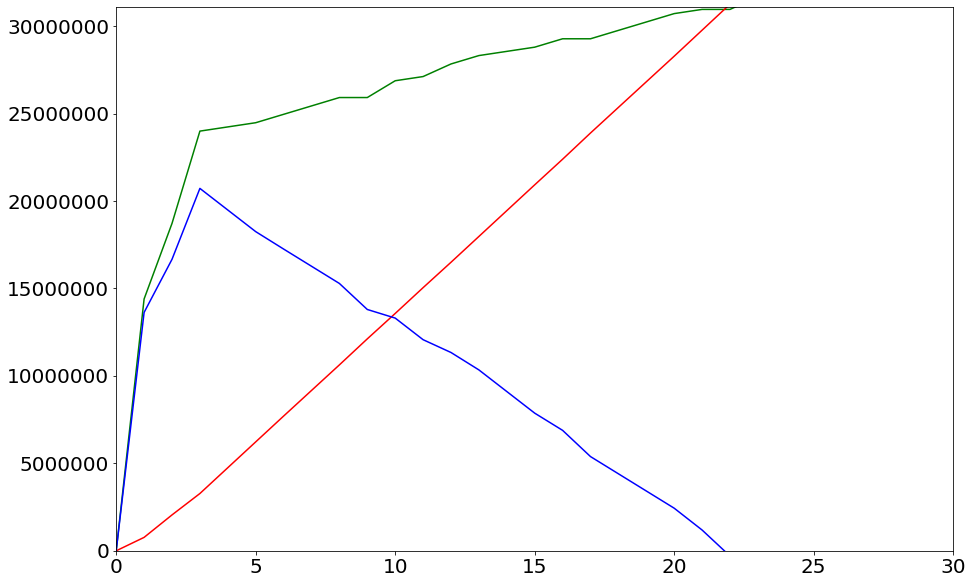

In [68]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [69]:
FDR3.to_csv('FDR3.csv')

In [70]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [71]:
print("duration: ", datetime.now() - start_time)

duration:  0:27:07.295743


In [72]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/Data sets/done/transactions/transactions 2023 new/give to students'

In [73]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: user 191 ms, sys: 46.5 ms, total: 237 ms
Wall time: 239 ms


(96397, 10)

In [74]:
df['prediction'] = model.predict_proba(X)[:,1]

In [75]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [76]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000873
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.000876
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.000897
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.000873
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000886


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  int64         
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           93199 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        95377 non-null  object        
 6   Merch zip          92097 non-null  float64       
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
 10  prediction         96397 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.8+ MB


In [78]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
60047,60048,5142138135,2010-08-04,900009045549,KRACKELER SCIENTIFIC,NY,12202.0,P,1664.87,1,1.000000
60031,60032,5142138135,2010-08-04,900009045549,KRACKELER SCIENTIFIC,NY,12202.0,P,24778.99,1,1.000000
60027,60028,5142138135,2010-08-04,900009045549,KRACKELER SCIENTIFIC,NY,12202.0,P,3058.56,1,1.000000
60004,60005,5142138135,2010-08-04,900009045549,KRACKELER SCIENTIFIC,NY,12202.0,P,173.19,1,1.000000
59998,59999,5142138135,2010-08-04,900009045549,KRACKELER SCIENTIFIC,NY,12202.0,P,9117.34,1,1.000000
59988,59989,5142138135,2010-08-04,900009045549,KRACKELER SCIENTIFIC,NY,12202.0,P,3437.71,1,1.000000
59933,59934,5142138135,2010-08-04,900009045549,KRACKELER SCIENTIFIC,NY,12202.0,P,1941.07,1,1.000000
59917,59918,5142138135,2010-08-04,900009045549,KRACKELER SCIENTIFIC,NY,12202.0,P,5454.92,1,1.000000
59914,59915,5142138135,2010-08-04,900009045549,KRACKELER SCIENTIFIC,NY,12202.0,P,324.50,1,1.000000
59911,59912,5142138135,2010-08-04,900009045549,KRACKELER SCIENTIFIC,NY,12202.0,P,10598.09,1,1.000000


In [79]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

5142140316    46
5142847398    45
5142199009    45
5142160778    41
5142189341    41
5142181728    39
5142212038    39
5142220919    38
5142214614    37
5142202847    37
5142138135    36
5142271065    34
5142152857    32
5142179617    32
5142235211    32
5142197711    32
5142182128    31
5142189113    30
5142197563    30
5142116864    28
Name: Cardnum, dtype: int64

In [80]:
bads['Merchnum'].value_counts().head(15)

4353000719908    107
930090121224      50
8834000695423     46
4503738417400     45
4620009957157     39
618901687330      36
900009045549      36
9108234610000     33
253052983001      33
938909877224      32
4503082476300     31
6006333528866     30
997674930332      29
6070095870009     27
9900020006406     25
Name: Merchnum, dtype: int64

In [81]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
# sample = df[df['Cardnum'] == card]
sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

107

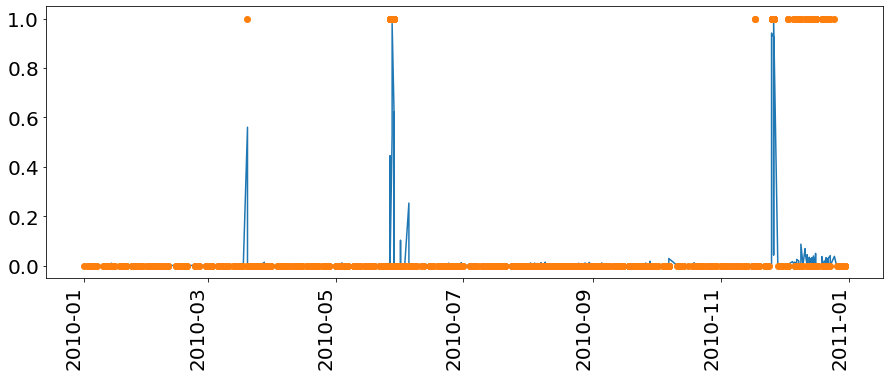

In [82]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [83]:
tsample = sample[sample['Date'] > '2010-11-09']
tsample = tsample[tsample['Date'] < '2010-12-01']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,86387,86388,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.002190
1,2,86406,86407,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.001906
2,3,86485,86486,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.001160
3,4,86802,86803,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.000849
4,5,86907,86908,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.000859


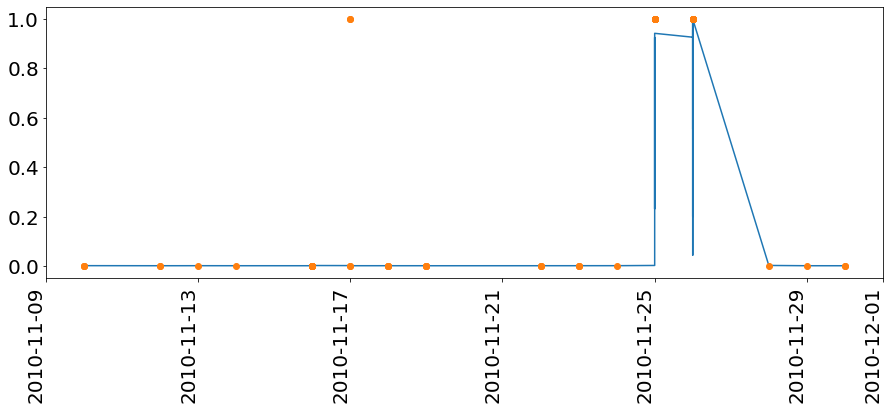

In [84]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])

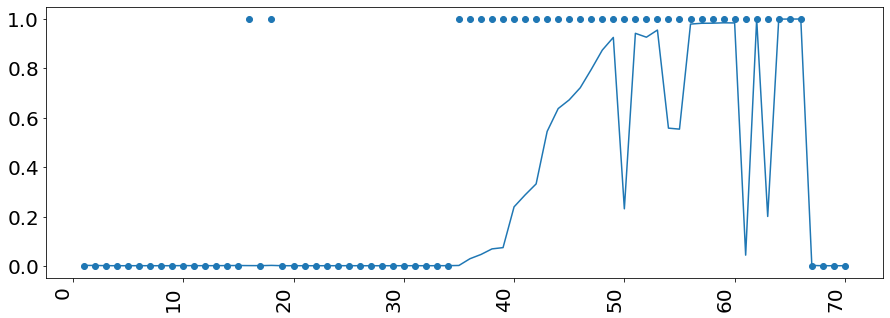

In [85]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])

In [86]:
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,86387,86388,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.002190
1,2,86406,86407,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.001906
2,3,86485,86486,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.001160
3,4,86802,86803,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.000849
4,5,86907,86908,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.000859
5,6,86984,86985,5142137416,2010-11-13,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.90,0,0.001019
6,7,87000,87001,5142236799,2010-11-14,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,98.60,0,0.000878
7,8,87282,87283,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,32.28,0,0.000859
8,9,87317,87318,5142226979,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.06,0,0.000955
9,10,87415,87416,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,234.54,0,0.001364


In [87]:
print("duration: ", datetime.now() - start_time)

duration:  0:27:08.262268
